# Resume NLP Project

This notebook demonstrates a basic NLP pipeline for:
1. Parsing job postings (HTML files)
2. Extracting relevant text tokens
3. Filtering out irrelevant postings
4. Clustering job postings with K-Means (and optionally Agglomerative Clustering)
5. Creating word clouds for each cluster
6. Comparing clustered skills to the skills listed in `resume.txt`

### 1. Setup and Text Preprocessing
#### First, we import our libraries, download necessary NLTK resources, and create text cleaning functions.
#### We include a version using lemmatization (you can also try stemming by using the alternative function).

In [3]:
import os
import re
import string

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

import nltk
from nltk import download
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

from wordcloud import WordCloud

# Uncomment if you haven't downloaded NLTK stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
# Keep 'r' in case we want to preserve R as a skill
if 'r' in stop_words:
    stop_words.remove('r')
    
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 100

## 2. Helper Functions

In [4]:
def tokenize_and_clean(text, stop_words=stop_words):
    """
    1. Lowercase
    2. Split on non-word chars
    3. Remove empty splits
    4. Filter out English stopwords (except 'r')
    5. Return a list of clean tokens
    """
    text = text.lower()
    tokens = re.split(r"\W+", text)
    tokens = [t for t in tokens if t]

    clean_tokens = []
    for tok in tokens:
        if tok in stop_words:
            continue
        clean_tokens.append(tok)
    return clean_tokens

def parse_html_tags(filepath, tags=("div", "ul", "li", "p")):
    """Parse the specified tags from an HTML file and return a set of tokens"""
    if not os.path.exists(filepath):
        return set()
    with open(filepath, 'r', encoding='utf-8') as f:
        html_content = f.read()
    soup = BeautifulSoup(html_content, "html.parser")

    tokens_aggregate = set()
    for tag_name in tags:
        elements = soup.find_all(tag_name)
        for el in elements:
            text = el.get_text(separator=" ", strip=True)
            tokens = tokenize_and_clean(text)
            tokens_aggregate.update(tokens)
    return tokens_aggregate

def get_top_terms_per_cluster(df, cluster_label_col, token_col="tag_tokens", top_n=10):
    """
    Returns a dictionary: cluster_id -> list of top_n token strings.
    """
    from collections import Counter
    cluster_terms = {}
    for cluster_id in sorted(df[cluster_label_col].unique()):
        subset_tokens = df.loc[df[cluster_label_col] == cluster_id, token_col]
        all_tokens = []
        for tokens in subset_tokens:
            all_tokens.extend(tokens)
        freq_counter = Counter(all_tokens)
        top_terms = [term for term, freq in freq_counter.most_common(top_n)]
        cluster_terms[cluster_id] = top_terms
    return cluster_terms

def plot_wordclouds_subplots(df, cluster_col, title_prefix, max_clusters=6, text_col="tag_text"):
    """
    Generates word clouds in a single figure with 3 rows x 2 columns of subplots,
    with reduced vertical/horizontal spacing.

    If a cluster has no text, we skip that subplot.
    """
    clusters = sorted(df[cluster_col].unique())

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16), facecolor="white")
    axes = axes.flatten()

    # Keep track of how many valid clusters we've plotted so far
    plot_index = 0

    for cluster_id in clusters[:max_clusters]:
        subset_texts = df.loc[df[cluster_col] == cluster_id, text_col]
        combined_text = " ".join(subset_texts)

        # Skip if there's no text for this cluster
        if not combined_text.strip():
            continue

        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(combined_text)

        # Plot on the subplot
        ax = axes[plot_index]
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"{title_prefix} Cluster {cluster_id}", fontsize=14)

        plot_index += 1
        if plot_index >= len(axes):
            break  # We've filled all subplots

    # Turn off any remaining empty subplots
    for j in range(plot_index, len(axes)):
        axes[j].axis("off")

    fig.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.8)
    plt.show()

# Define a function to clean text:
def clean_text(text):
    """
    Lowercases text, removes punctuation, tokenizes, removes stopwords, and lemmatizes the tokens.
    """
    text = text.lower()
    text = re.sub('['+string.punctuation+']', ' ', text)
    tokens = nltk.word_tokenize(text)
    filtered = [w for w in tokens if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in filtered]
    return " ".join(lemmatized)

# Optional: stemming alternative (if you wish to experiment)
def clean_text_stem(text):
    """
    Lowercases text, removes punctuation, tokenizes, removes stopwords, and stems the tokens.
    """
    text = text.lower()
    text = re.sub('['+string.punctuation+']', ' ', text)
    tokens = nltk.word_tokenize(text)
    filtered = [w for w in tokens if w not in stopwords.words('english')]
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(w) for w in filtered]
    return " ".join(stemmed)

## 3. Parse the Job Postings and Create `df_jobs_model`

In [3]:
job_postings_dir = "./data/job_postings"  # adjust if needed

records = []
for file_name in os.listdir(job_postings_dir):
    if file_name.endswith(".html"):
        tokens = parse_html_tags(
            os.path.join(job_postings_dir, file_name), 
            tags=("div", "ul", "li", "p")
        )
        records.append({
            "filename": file_name,
            "tag_tokens": list(tokens)  # store as list if we want later iteration
        })

# Create a DataFrame of job postings
df_jobs_model = pd.DataFrame(records)
print("df_jobs_model.info() =>")
df_jobs_model.info()

# Convert tokens to a single string of text for each row
df_jobs_model["tag_text"] = df_jobs_model["tag_tokens"].apply(lambda tok: " ".join(tok))

df_jobs_model.head()

df_jobs_model.info() =>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    1458 non-null   object
 1   tag_tokens  1458 non-null   object
dtypes: object(2)
memory usage: 22.9+ KB


,filename,tag_tokens,tag_text
0,fb17842d02292e83.html,"[worked, driven, frontend, new, national, anal...",worked driven frontend new national analytics ...
1,06e2c7659a3199e9.html,"[research, maintenance, national, implement, a...",research maintenance national implement age ov...
2,c49bf5a9b76b6943.html,"[70, offer, based, processes, package, reviews...",70 offer based processes package reviews airwo...
3,0c569e6055392385.html,"[exceeds, science, computer, configurations, f...",exceeds science computer configurations flashe...
4,0a22c5c79af5fcf8.html,"[worked, clustering, mental, developers, dataw...",worked clustering mental developers datawareho...


## 4. K-Means Clustering

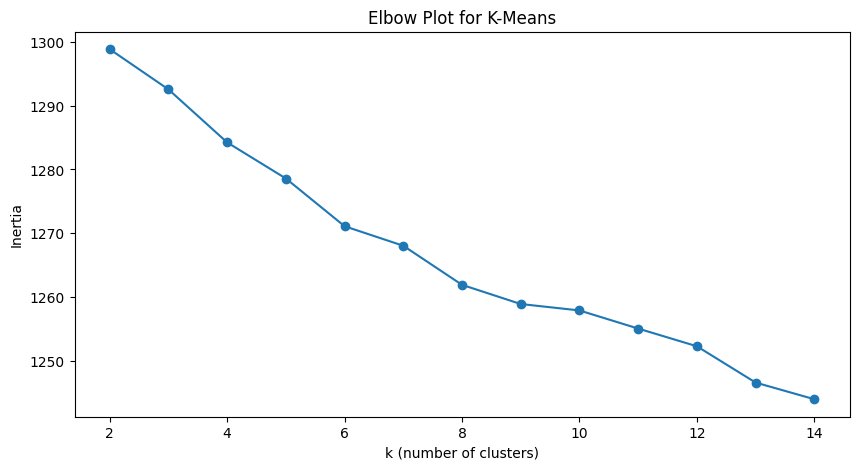

k_means_cluster_label
5    632
4    382
1    337
3     59
2     38
0     10
Name: count, dtype: int64

In [10]:
# We'll do a quick K-Means example with an elbow plot

X_text = df_jobs_model["tag_text"].values

k_values = range(2, 15)  # try 2..9 clusters
inertias = []
for k in k_values:
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("kmeans", KMeans(n_clusters=k, random_state=42))
    ])
    pipe.fit(X_text)
    inertias.append(pipe.named_steps["kmeans"].inertia_)

plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.title("Elbow Plot for K-Means")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.show()

# Choose an arbitrary k based on elbow or domain knowledge
optimal_k = 6
kmeans_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("kmeans", KMeans(n_clusters=optimal_k, random_state=42))
])

kmeans_pipe.fit(X_text)

# Assign cluster labels
df_jobs_model["k_means_cluster_label"] = kmeans_pipe.predict(X_text)
df_jobs_model["k_means_cluster_label"].value_counts()

## 5. Agglomerative Clustering (Cosine Distance)

In [5]:
# We'll compute a TF-IDF matrix, then do Agglomerative Clustering on (1 - cosine_similarity)

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df_jobs_model["tag_text"])

similarity_matrix = cosine_similarity(X_tfidf)
distance_matrix = 1 - similarity_matrix

n_clusters = 5
agglo = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric="manhattan",
    linkage="complete",
    distance_threshold=None
)

labels = agglo.fit_predict(distance_matrix)
df_jobs_model["agglo_cluster_label"] = labels

df_jobs_model["agglo_cluster_label"].value_counts()

agglo_cluster_label
2    449
1    407
0    407
4    100
3     95
Name: count, dtype: int64

## 6. Visualize Each Cluster (Word Clouds)

We’ll produce 2 separate figures, each containing 3 rows × 2 columns of subplots (up to 6 clusters).

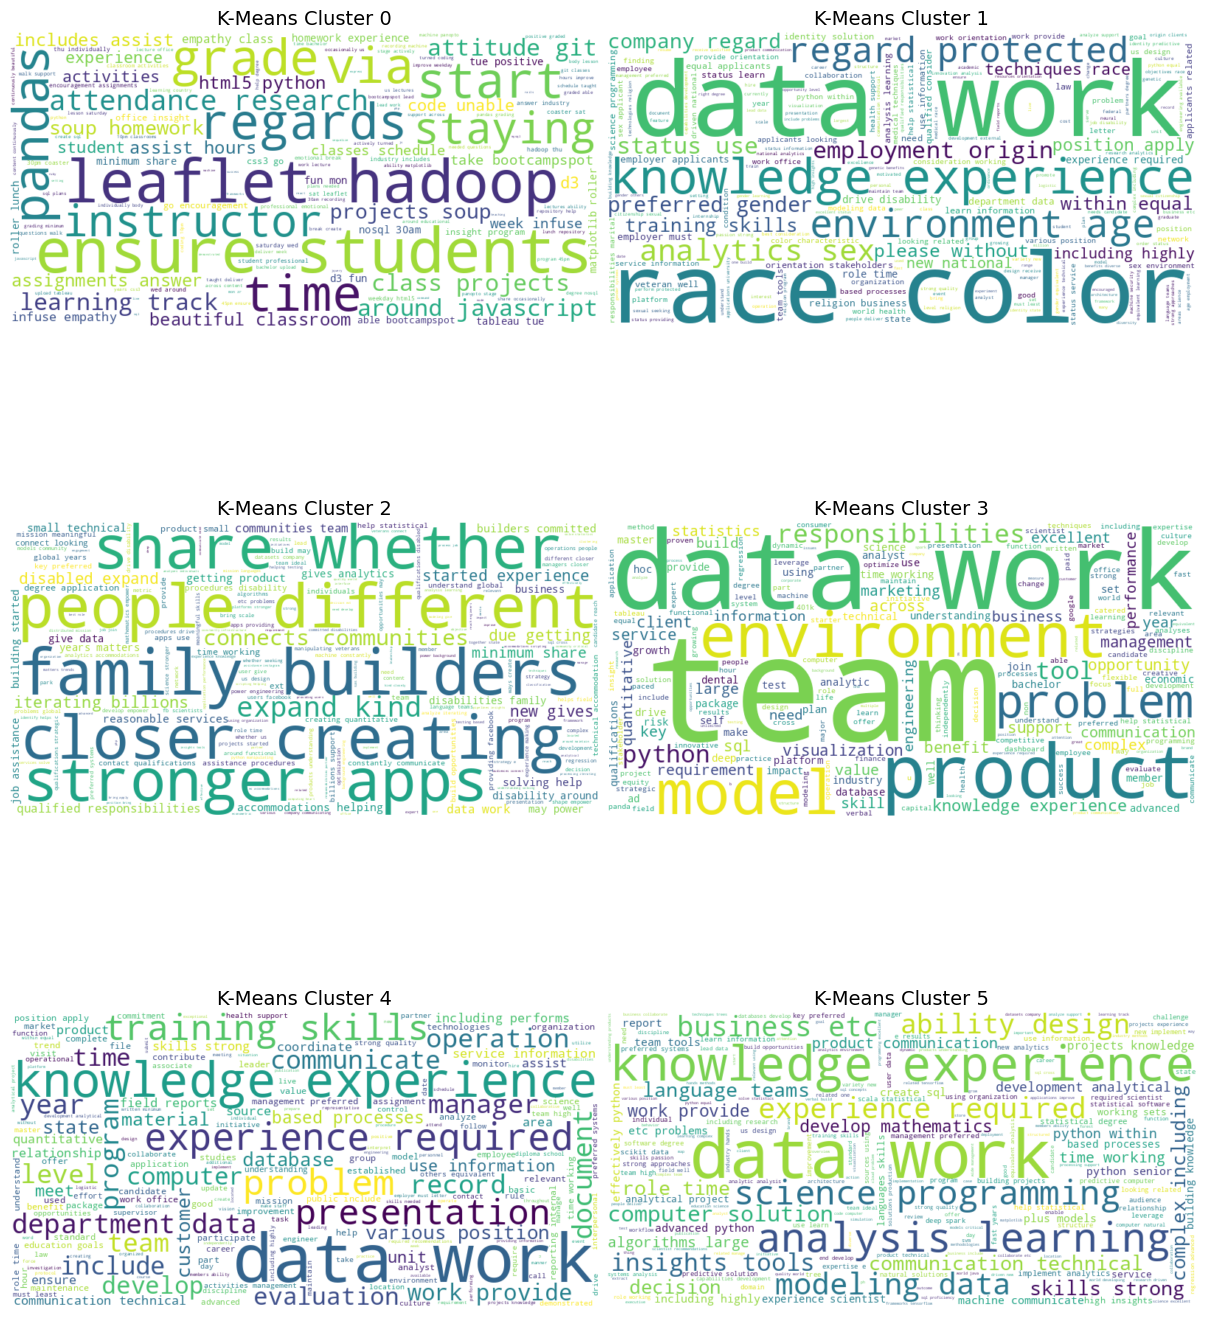

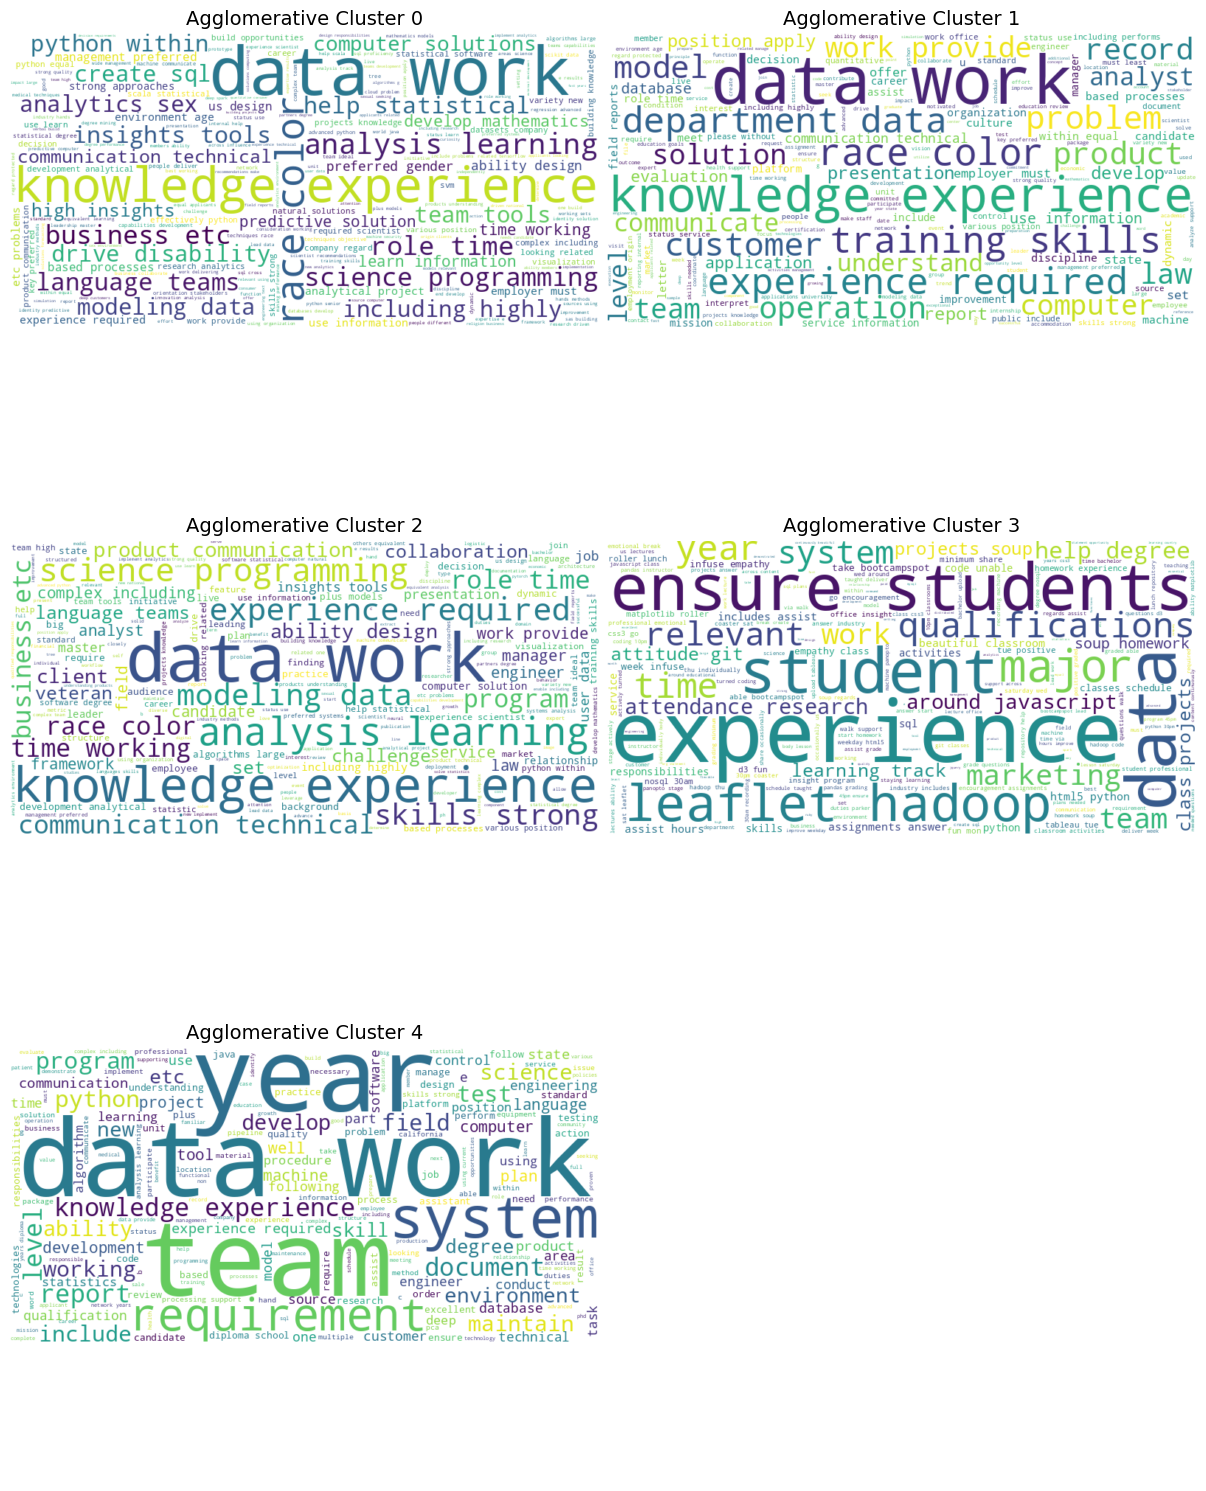

In [6]:
# K-Means word clouds
plot_wordclouds_subplots(
    df=df_jobs_model,
    cluster_col="k_means_cluster_label",
    title_prefix="K-Means",
    max_clusters=6,
    text_col="tag_text"
)

# Agglomerative word clouds
plot_wordclouds_subplots(
    df=df_jobs_model,
    cluster_col="agglo_cluster_label",
    title_prefix="Agglomerative",
    max_clusters=6,
    text_col="tag_text"
)

## 7. Compare Clustered Skills to Your Resume

We'll parse a list of your resume skills and compare to the top terms in each cluster.

In [7]:
# 7a. Extract resume skills
resume_path = "./data/resume.txt"  # adjust if needed
with open(resume_path, "r", encoding="utf-8") as f:
    resume_text = f.read()
resume_lower = resume_text.lower()

# Potentially relevant DS/ML skill keywords
potential_skills = [
    "python", "r", "sql", "java", "c++", "machine learning", "ml", 
    "deep learning", "nlp", "ai", "tensorflow", "pytorch", 
    "statistics", "power bi", "tableau", "spark", 
    "hadoop", "excel", "azure", "aws", "gcp", "pandas", "numpy"
]

resume_skills = set()
for skill in potential_skills:
    if skill in resume_lower:
        resume_skills.add(skill)

print("Skills found in resume:")
print(resume_skills)

# 7b. Get top 10 terms in each cluster
kmeans_top_terms = get_top_terms_per_cluster(df_jobs_model, "k_means_cluster_label", top_n=10)

for cluster_id, terms in kmeans_top_terms.items():
    terms_set = set(terms)
    overlap = terms_set.intersection(resume_skills)
    missing = terms_set - resume_skills
    print(f"\nK-Means Cluster {cluster_id}")
    print("Top Terms:", terms)
    print("Already in Resume:", overlap)
    print("Potential Missing Skills:", missing)

# 7c. Repeat for Agglomerative
agglo_top_terms = get_top_terms_per_cluster(df_jobs_model, "agglo_cluster_label", top_n=10)
for cluster_id, terms in agglo_top_terms.items():
    terms_set = set(terms)
    overlap = terms_set.intersection(resume_skills)
    missing = terms_set - resume_skills
    print(f"\nAgglomerative Cluster {cluster_id}")
    print("Top Terms:", terms)
    print("Already in Resume:", overlap)
    print("Potential Missing Skills:", missing)


Skills found in resume:
{'nlp', 'pandas', 'r', 'numpy'}

K-Means Cluster 0
Top Terms: ['nosql', 'leaflet', 'hadoop', 'machine', 'ensure', 'students', 'around', 'class', 'css3', 'student']
Already in Resume: set()
Potential Missing Skills: {'nosql', 'leaflet', 'students', 'hadoop', 'around', 'css3', 'class', 'student', 'machine', 'ensure'}

K-Means Cluster 1
Top Terms: ['data', 'experience', 'national', 'race', 'status', 'work', 'disability', 'origin', 'orientation', 'opportunity']
Already in Resume: set()
Potential Missing Skills: {'orientation', 'disability', 'experience', 'national', 'opportunity', 'status', 'race', 'origin', 'data', 'work'}

K-Means Cluster 2
Top Terms: ['accommodations', 'people', 'experience', 'due', 'accommodation', 'minimum', 'share', 'us', 'qualified', 'responsibilities']
Already in Resume: set()
Potential Missing Skills: {'experience', 'due', 'people', 'qualified', 'responsibilities', 'accommodation', 'accommodations', 'minimum', 'share', 'us'}

K-Means Cluste

## 8. (Optional) Compare the Two Clusterings

You can create a **cross-tab** to see how K-Means labels map onto Agglomerative labels, or compute metrics like **Adjusted Rand Index**.

In [8]:
# Cross-tab
ctab = pd.crosstab(
    df_jobs_model["k_means_cluster_label"], 
    df_jobs_model["agglo_cluster_label"]
)
print("Cross-tab of K-Means vs Agglomerative")
print(ctab)

# ARI and NMI
k_labels = df_jobs_model["k_means_cluster_label"].values
a_labels = df_jobs_model["agglo_cluster_label"].values

ari = adjusted_rand_score(k_labels, a_labels)
nmi = normalized_mutual_info_score(k_labels, a_labels)
print("\nAdjusted Rand Index (K-Means vs. Agglo):", ari)
print("Normalized Mutual Info:", nmi)

Cross-tab of K-Means vs Agglomerative
agglo_cluster_label      0    1    2   3   4
k_means_cluster_label                       
0                        0    0    0  10   0
1                      113  132   91   0   1
2                       26    0   12   0   0
3                       12   12   24   8   3
4                        0  212   43  72  55
5                      256   51  279   5  41

Adjusted Rand Index (K-Means vs. Agglo): 0.16074298655260602
Normalized Mutual Info: 0.22197124870204413


## Conclusion

This notebook demonstrates an end-to-end pipeline to **parse job postings**, **extract tokens**, **cluster** them, **visualize** via word clouds, and **compare** cluster-based skill demands with your resume skill set. Explore parameters (like `n_clusters`, `distance_threshold`, `max_df/min_df` in `TfidfVectorizer`) to see how your results change and to refine your analysis.